# Salary Prediction and Bias Analysis

Análise de dados salariais da base de dados do governo brasileiro Relação Anual de Informações Sociais (RAIS). Especificamente, esses são dados referentes ao estado de São Paulo do ano de 2019.

A proposta desse projeto é realizar uma análise do padrão salarial dos funcionários da área da computação, procurar por possíveis disparidades e viéses existentes e verificar se tais disparidades são presentes em um possível modelo de predição salarial. São usados no modelo tanto dados de cunho técnico, como nível de escolaridade, quanto dados de cunho social, como raça e sexo.

A preocupação desses modelos com os dados da RAIS NÃO É obter uma precisão alta em um modelo preditivo. A proposta com esses dados é realizar a análise de viés do modelo de IA com os dados, enquanto a predição salarial em si fica com outros *datasets*.

## Coisas a fazer

Comparar dados do resultado da predição com os dados reais, principalmente das classes 7 e 8.

Remover Outliers por grupos segregados

Aplicar proposta do Método de Consistência (ao menos resultados e conclusão textual)

# Preparos básicos

## Imports

In [ ]:
# visualization

  # matplotlib

import matplotlib as m
import matplotlib.pyplot as plt

  # matplotlib styles

from pylab import rcParams

plt.style.use('fivethirtyeight')

m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['axes.labelsize'] = 14

rcParams['figure.figsize'] = 16, 8

%matplotlib inline

  # seaborn

import seaborn as sns

# numbers

  # numpy

import numpy as np

# data

  # get data

    # colab

from google.colab import drive

  # big data

    # pyspark dependencies

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

from pyspark.sql.functions import col, regexp_replace, trim, lit, when

from functools import reduce

  # filtered data

    # pandas

import pandas as pd

# normality tests

  # shapiro-wilk and kolmogorov-smirnov

from scipy.stats import shapiro, kstest

# hypothesis tests

  # mann-whitney u

import scipy.stats as stats

# models

  # prepocessing

!pip install category_encoders

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders.cat_boost import CatBoostEncoder

  # model evaluations

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

  # classification statistical models

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

  # regression statistical models

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.4 MB/s eta 0:00:00


## Montagem do drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Preparos para carregamento dos dados

In [ ]:
COL_NAMES = (
    "bairros_sp", "bairros_fortaleza", "bairros_rj",
    "causa_afastamento_1", "causa_afastamento_2", "causa_afastamento_3",
    "Motivo_Desligamento", "cbo_ocupacao_2002", "cnae_20_classe", "cnae_95_classe",
    "distritos_sp", "vinculo_ativo_31_12", "faixa_etaria", "faixa_hora_contrat",
    "faixa_remun_dezem_sm", "faixa_remun_media_sm", "faixa_tempo_emprego",
    "escolaridade_apos_2005", "qtd_hora_contr", "idade", "ind_cei_vinculado",
    "ind_simples", "mes_admissao", "mes_desligamento", "mun_trab", "municipio",
    "nacionalidade", "natureza_juridica", "ind_portador_defic", "qtd_dias_afastamento",
    "raca_cor", "regioes_adm_df", "vl_remun_dezembro_nom", "vl_remun_dezembro_sm",
    "vl_remun_media_nom", "vl_remun_media_sm", "cnae_20_subclasse", "sexo_trabalhador",
    "tamanho_estabelecimento", "tempo_emprego", "tipo_admissao", "tipo_estab1", "tipo_estab2",
    "tipo_defic", "tipo_vinculo", "ibge_subsetor", "vl_rem_janeiro_cc", "vl_rem_fevereiro_cc",
    "vl_rem_marco_cc", "vl_rem_abril_cc", "vl_rem_maio_cc", "vl_rem_junho_cc", "vl_rem_julho_cc",
    "vl_rem_agosto_cc", "vl_rem_setembro_cc", "vl_rem_outubro_cc", "vl_rem_novembro_cc",
    "ano_chegada_brasil", "ind_trab_intermitente", "ind_trab_parcial"
)

file_path = "drive/MyDrive/catholic/article/microdados/"

# Pré-processamento e análise dos dados em pyspark

## Pré-processamento

### Carregar dados no pypark

In [ ]:
df = spark.read.csv(file_path+"RAIS_VINC_PUB_SP.csv", sep=";", multiLine=True, inferSchema=True)

### Tratar nome das colunas

In [ ]:
old_columns = df.schema.names

df = reduce(lambda df, i: df.withColumnRenamed(old_columns[i], COL_NAMES[i]),
            range(len(old_columns)), df)

df.printSchema()

root
 |-- bairros_sp: string (nullable = true)
 |-- bairros_fortaleza: string (nullable = true)
 |-- bairros_rj: string (nullable = true)
 |-- causa_afastamento_1: string (nullable = true)
 |-- causa_afastamento_2: string (nullable = true)
 |-- causa_afastamento_3: string (nullable = true)
 |-- Motivo_Desligamento: string (nullable = true)
 |-- cbo_ocupacao_2002: string (nullable = true)
 |-- cnae_20_classe: string (nullable = true)
 |-- cnae_95_classe: string (nullable = true)
 |-- distritos_sp: string (nullable = true)
 |-- vinculo_ativo_31_12: string (nullable = true)
 |-- faixa_etaria: string (nullable = true)
 |-- faixa_hora_contrat: string (nullable = true)
 |-- faixa_remun_dezem_sm: string (nullable = true)
 |-- faixa_remun_media_sm: string (nullable = true)
 |-- faixa_tempo_emprego: string (nullable = true)
 |-- escolaridade_apos_2005: string (nullable = true)
 |-- qtd_hora_contr: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- ind_cei_vinculado: string (null

In [ ]:
df.head(2)

[Row(bairros_sp='Bairros SP', bairros_fortaleza='Bairros Fortaleza', bairros_rj='Bairros RJ', causa_afastamento_1='Causa Afastamento 1', causa_afastamento_2='Causa Afastamento 2', causa_afastamento_3='Causa Afastamento 3', Motivo_Desligamento='Motivo Desligamento', cbo_ocupacao_2002='CBO Ocupa��o 2002', cnae_20_classe='CNAE 2.0 Classe', cnae_95_classe='CNAE 95 Classe', distritos_sp='Distritos SP', vinculo_ativo_31_12='V�nculo Ativo 31/12', faixa_etaria='Faixa Et�ria', faixa_hora_contrat='Faixa Hora Contrat', faixa_remun_dezem_sm='Faixa Remun Dezem (SM)', faixa_remun_media_sm='Faixa Remun M�dia (SM)', faixa_tempo_emprego='Faixa Tempo Emprego', escolaridade_apos_2005='Escolaridade ap�s 2005', qtd_hora_contr='Qtd Hora Contr', idade='Idade', ind_cei_vinculado='Ind CEI Vinculado', ind_simples='Ind Simples', mes_admissao='M�s Admiss�o', mes_desligamento='M�s Desligamento', mun_trab='Mun Trab', municipio='Munic�pio', nacionalidade='Nacionalidade', natureza_juridica='Natureza Jur�dica', ind_po

### Tratamento básico das strings

#### Substituir vírgulas por ponto

In [ ]:
df = df.withColumn('vl_remun_media_nom', regexp_replace(df.vl_remun_media_sm, ',', '.'))
df = df.withColumn('vl_remun_media_sm', regexp_replace(df.vl_remun_media_sm, ',', '.'))

df = df.withColumn('vl_remun_dezembro_nom', regexp_replace(df.vl_remun_dezembro_nom, ',', '.'))
df = df.withColumn('vl_remun_dezembro_sm', regexp_replace(df.vl_remun_dezembro_sm, ',', '.'))

df = df.withColumn('vl_rem_janeiro_cc', regexp_replace(df.vl_rem_janeiro_cc, ',', '.'))
df = df.withColumn('vl_rem_fevereiro_cc', regexp_replace(df.vl_rem_fevereiro_cc, ',', '.'))
df = df.withColumn('vl_rem_marco_cc', regexp_replace(df.vl_rem_marco_cc, ',', '.'))
df = df.withColumn('vl_rem_abril_cc', regexp_replace(df.vl_rem_abril_cc, ',', '.'))
df = df.withColumn('vl_rem_maio_cc', regexp_replace(df.vl_rem_maio_cc, ',', '.'))
df = df.withColumn('vl_rem_junho_cc', regexp_replace(df.vl_rem_junho_cc, ',', '.'))
df = df.withColumn('vl_rem_julho_cc', regexp_replace(df.vl_rem_julho_cc, ',', '.'))
df = df.withColumn('vl_rem_agosto_cc', regexp_replace(df.vl_rem_agosto_cc, ',', '.'))
df = df.withColumn('vl_rem_setembro_cc', regexp_replace(df.vl_rem_setembro_cc, ',', '.'))
df = df.withColumn('vl_rem_outubro_cc', regexp_replace(df.vl_rem_outubro_cc, ',', '.'))
df = df.withColumn('vl_rem_novembro_cc', regexp_replace(df.vl_rem_novembro_cc, ',', '.'))

df = df.withColumn('tempo_emprego', regexp_replace(df.tempo_emprego, ',', '.'))

#### Remover \r

In [ ]:
df = df.withColumn('ind_trab_parcial', regexp_replace(df.ind_trab_parcial, '\r', ''))

#### Remover não-ASCII

In [ ]:
#for column in COL_NAMES:
#  df[column] = df[column].str.encode('ascii', 'ignore').str.decode('ascii')

#### Limpar espaços em branco

In [ ]:
df = df.withColumn("tempo_emprego", trim(df.tempo_emprego))
df = df.withColumn("bairros_sp", trim(df.bairros_sp))
df = df.withColumn("bairros_fortaleza", trim(df.bairros_fortaleza))
df = df.withColumn("bairros_rj", trim(df.bairros_rj))
df = df.withColumn("distritos_sp", trim(df.distritos_sp))
df = df.withColumn("escolaridade_apos_2005", trim(df.escolaridade_apos_2005))
df = df.withColumn("qtd_hora_contr", trim(df.qtd_hora_contr))
df = df.withColumn("idade", trim(df.idade))
df = df.withColumn("qtd_dias_afastamento", trim(df.qtd_dias_afastamento))
df = df.withColumn("sexo_trabalhador", trim(df.sexo_trabalhador))
df = df.withColumn("tempo_emprego", trim(df.tempo_emprego))
df = df.withColumn("tipo_estab2", trim(df.tipo_estab2))

#### Remover bairros de Fortaleza e RJ

In [ ]:
cols_to_drop = ["bairros_fortaleza", "bairros_rj"]
df = df.drop(*cols_to_drop)

In [ ]:
df.head(10)

[Row(bairros_sp='Bairros SP', causa_afastamento_1='Causa Afastamento 1', causa_afastamento_2='Causa Afastamento 2', causa_afastamento_3='Causa Afastamento 3', Motivo_Desligamento='Motivo Desligamento', cbo_ocupacao_2002='CBO Ocupa��o 2002', cnae_20_classe='CNAE 2.0 Classe', cnae_95_classe='CNAE 95 Classe', distritos_sp='Distritos SP', vinculo_ativo_31_12='V�nculo Ativo 31/12', faixa_etaria='Faixa Et�ria', faixa_hora_contrat='Faixa Hora Contrat', faixa_remun_dezem_sm='Faixa Remun Dezem (SM)', faixa_remun_media_sm='Faixa Remun M�dia (SM)', faixa_tempo_emprego='Faixa Tempo Emprego', escolaridade_apos_2005='Escolaridade ap�s 2005', qtd_hora_contr='Qtd Hora Contr', idade='Idade', ind_cei_vinculado='Ind CEI Vinculado', ind_simples='Ind Simples', mes_admissao='M�s Admiss�o', mes_desligamento='M�s Desligamento', mun_trab='Mun Trab', municipio='Munic�pio', nacionalidade='Nacionalidade', natureza_juridica='Natureza Jur�dica', ind_portador_defic='Ind Portador Defic', qtd_dias_afastamento='Qtd Dia

### Agrupamento textual por CNAE

In [ ]:
df = df.withColumn("area_atuacao_cnae", lit(None))
df.createOrReplaceTempView("DF")

# filter by informacao
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("58"), "informação") \
              .when(df.cnae_20_classe.startswith("59"), "informação") \
              .when(df.cnae_20_classe.startswith("60"), "informação") \
              .when(df.cnae_20_classe.startswith("61"), "informação") \
              .when(df.cnae_20_classe.startswith("62"), "informação") \
              .when(df.cnae_20_classe.startswith("63"), "informação") \
              .otherwise(df.area_atuacao_cnae))

# filter by saude
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("86"), "saúde") \
              .when(df.cnae_20_classe.startswith("87"), "saúde") \
              .when(df.cnae_20_classe.startswith("88"), "saúde") \
              .otherwise(df.area_atuacao_cnae))

# filter by gestao_residuos
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("36"), "gestão de resíduos") \
              .when(df.cnae_20_classe.startswith("37"), "gestão de resíduos") \
              .when(df.cnae_20_classe.startswith("38"), "gestão de resíduos") \
              .when(df.cnae_20_classe.startswith("39"), "gestão de resíduos") \
              .otherwise(df.area_atuacao_cnae))

# filter by construcao
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("41"), "construção") \
              .when(df.cnae_20_classe.startswith("42"), "construção") \
              .when(df.cnae_20_classe.startswith("43"), "construção") \
              .otherwise(df.area_atuacao_cnae))

# filter by cient_tec
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("69"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("70"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("71"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("72"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("73"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("74"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("75"), "científicos e tecnologia") \
              .otherwise(df.area_atuacao_cnae))
df.filter(df.cnae_20_classe.startswith("58") | df.cnae_20_classe.startswith("59")).show()

+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------------+--------------+------------+-------------------+------------+------------------+--------------------+--------------------+-------------------+----------------------+--------------+-----+-----------------+-----------+------------+----------------+--------+---------+-------------+-----------------+------------------+--------------------+--------+--------------+---------------------+--------------------+------------------+-----------------+-----------------+----------------+-----------------------+-------------+-------------+-----------+-----------+----------+------------+-------------+-----------------+-------------------+---------------+---------------+--------------+---------------+---------------+----------------+------------------+-----------------+------------------+------------------+---------------------+----------------+-----------------+
|bairros_sp|causa_

### Agrupamento textual por CBO

In [ ]:
df = df.withColumn("area_atuacao_cbo", lit(None))
df.createOrReplaceTempView("DF")

# forças armadas
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("0"), "forças armadas") \
              .otherwise(df.area_atuacao_cbo))

# poder público
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("1"), "poder público") \
              .otherwise(df.area_atuacao_cbo))

# ciências e artes (informática inclusa)
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("212"), "ciências e artes") \
              .otherwise(df.area_atuacao_cbo))

# técnicos nível médio
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("3"), "técnicos nível médio") \
              .otherwise(df.area_atuacao_cbo))

# serviços administrativos
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("4"), "serviços administrativos") \
              .otherwise(df.area_atuacao_cbo))

# serviços de comércio
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("5"), "serviços de comércio") \
              .otherwise(df.area_atuacao_cbo))

# serviços rurais
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("6"), "serviços rurais") \
              .otherwise(df.area_atuacao_cbo))

# serviços industriais 1
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("7"), "serviços industriais 1") \
              .otherwise(df.area_atuacao_cbo))

# serviços industriais 2
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("8"), "serviços industriais 2") \
              .otherwise(df.area_atuacao_cbo))

# serviços de manutenção
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("9"), "serviços de manutenção") \
              .otherwise(df.area_atuacao_cbo))

df.filter(df.cbo_ocupacao_2002.startswith("0") | df.cbo_ocupacao_2002.startswith("2")).show()

+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------------+--------------+------------+-------------------+------------+------------------+--------------------+--------------------+-------------------+----------------------+--------------+-----+-----------------+-----------+------------+----------------+--------+---------+-------------+-----------------+------------------+--------------------+--------+--------------+---------------------+--------------------+------------------+-----------------+-----------------+----------------+-----------------------+-------------+-------------+-----------+-----------+----------+------------+-------------+-----------------+-------------------+---------------+---------------+--------------+---------------+---------------+----------------+------------------+-----------------+------------------+------------------+---------------------+----------------+-----------------+----------------+
|

## Segregações para análise salarial

### Filtro geral

In [ ]:
clt_values = [10, 15, 20, 25, 60, 65, 70, 75]
comp_df = df.filter(df.tipo_vinculo.isin(clt_values))

comp_df = comp_df.filter((comp_df.area_atuacao_cbo == "ciências e artes"))  # funcionário da área de ciências e artes (inclui computação)
comp_df = comp_df.filter(comp_df.area_atuacao_cnae == "informação")  # empresa da área da informática # removed for now

comp_df = comp_df.filter((comp_df.escolaridade_apos_2005 > 8) & (comp_df.vl_remun_media_sm >= 1) & (comp_df.vl_remun_media_sm < 12) & (comp_df.faixa_etaria >= 3))
#comp_df = comp_df.filter((comp_df.escolaridade_apos_2005 > 5) & (comp_df.vl_remun_media_sm >= 1) & (comp_df.vl_remun_media_sm < 12))

df_male = comp_df.filter((comp_df.sexo_trabalhador == 1))
df_female = comp_df.filter((comp_df.sexo_trabalhador == 2))

In [ ]:
# all salary related columns that aren't Y + columns that give
# non-ascii characters related errors

cols_to_drop = (
    "faixa_remun_dezem_sm",
    "vl_remun_dezembro_nom", "vl_remun_media_nom",
    "vl_remun_dezembro_sm",
    "vl_rem_janeiro_cc", "vl_rem_fevereiro_cc", "vl_rem_marco_cc",
    "vl_rem_abril_cc", "vl_rem_maio_cc", "vl_rem_junho_cc",
    "vl_rem_julho_cc", "vl_rem_agosto_cc", "vl_rem_setembro_cc",
    "vl_rem_outubro_cc", "vl_rem_novembro_cc",
    "tipo_estab2",
    "area_atuacao_cnae", "area_atuacao_cbo",
    "regioes_adm_df", "bairros_sp", "distritos_sp",
    "mes_desligamento", "tempo_emprego",
    "cnae_95_classe", "novas_faixas_salariais",
)

# remove outliers by segregation based on boxplots generated in the beggining

classification_comp_df = comp_df.drop(*cols_to_drop)

classification_comp_df.columns

['causa_afastamento_1',
 'causa_afastamento_2',
 'causa_afastamento_3',
 'Motivo_Desligamento',
 'cbo_ocupacao_2002',
 'cnae_20_classe',
 'vinculo_ativo_31_12',
 'faixa_etaria',
 'faixa_hora_contrat',
 'faixa_remun_media_sm',
 'faixa_tempo_emprego',
 'escolaridade_apos_2005',
 'qtd_hora_contr',
 'idade',
 'ind_cei_vinculado',
 'ind_simples',
 'mes_admissao',
 'mun_trab',
 'municipio',
 'nacionalidade',
 'natureza_juridica',
 'ind_portador_defic',
 'qtd_dias_afastamento',
 'raca_cor',
 'vl_remun_media_sm',
 'cnae_20_subclasse',
 'sexo_trabalhador',
 'tamanho_estabelecimento',
 'tipo_admissao',
 'tipo_estab1',
 'tipo_defic',
 'tipo_vinculo',
 'ibge_subsetor',
 'ano_chegada_brasil',
 'ind_trab_intermitente',
 'ind_trab_parcial']

In [ ]:
panda_comp_df = classification_comp_df.toPandas()

In [ ]:
for c in panda_comp_df.columns.tolist():
  panda_comp_df[c] = pd.to_numeric(panda_comp_df[c])

### Impacto de fatores objetivos + idade

#### CBO

cbo_ocupacao_2002: [212205 212210 212215 212305 212310 212315 212320 212405 212410 212415
 212420]


<BarContainer object of 11 artists>

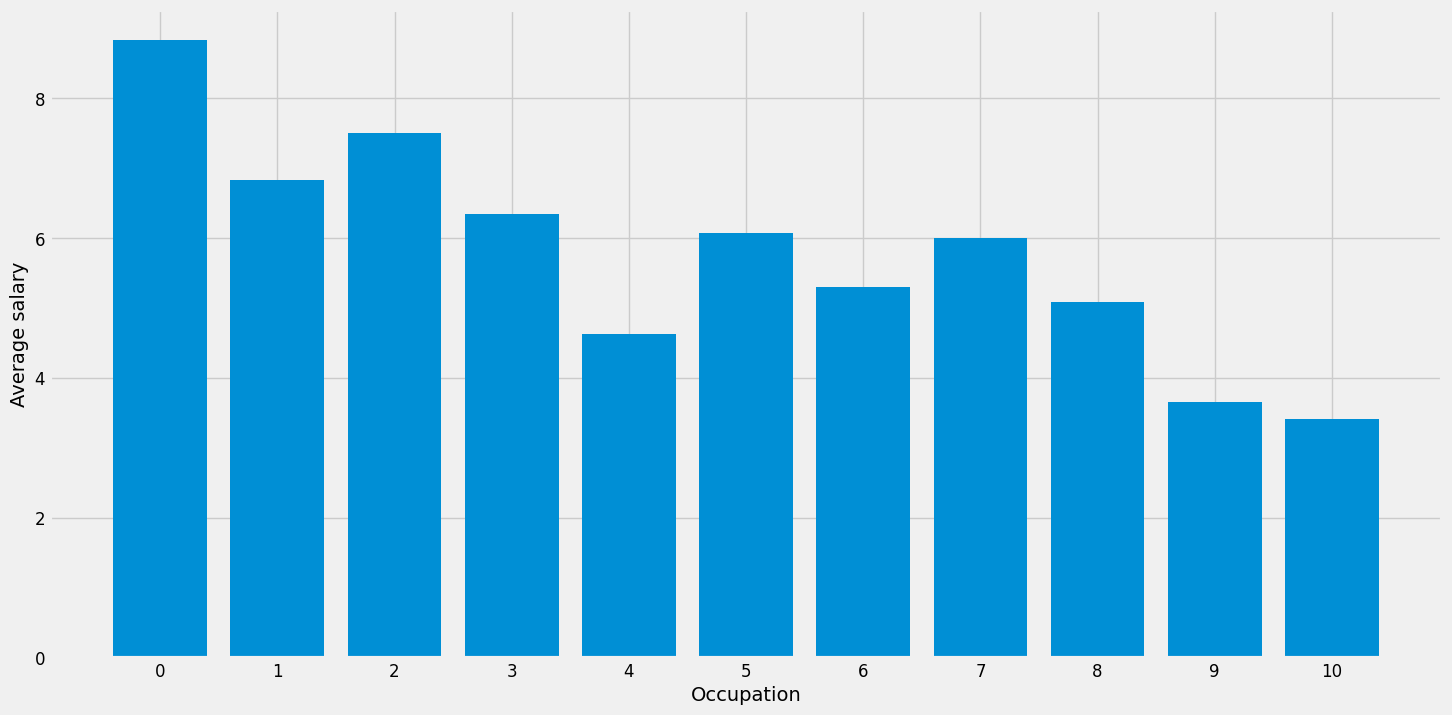

In [ ]:
values = np.sort(pd.unique(panda_comp_df["cbo_ocupacao_2002"]))
print("cbo_ocupacao_2002:", values)

x = []
y = []
for i, j in enumerate(values):
  tmp = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == j, ["vl_remun_media_sm"]]
  #x.append(str(j))
  x.append(str(i))
  y.append(tmp["vl_remun_media_sm"].median())

# plot

#plt.title("Average Salary By Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average salary")

plt.bar(x, y)

In [ ]:
# H0 - a == b
# H1 - b != b

tmp1 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[0], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[4], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"0 ==  4: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[0], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[9], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"0 ==  9: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[2], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[5], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"2 ==  5: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[2], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[7], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"2 ==  7: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[3], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[9], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"3 ==  9: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[3], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cbo_ocupacao_2002"] == values[10], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"2 == 10: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

0 ==  4: [statistic=415029.0, pvalue=4.037886528863605e-79]
0 ==  9: [statistic=450288.0, pvalue=1.8932484971555554e-119]
2 ==  5: [statistic=121963.5, pvalue=6.347750189527503e-11]
2 ==  7: [statistic=143555.5, pvalue=1.8282345737480948e-34]
3 ==  9: [statistic=572897.5, pvalue=2.9381873460110744e-55]
2 == 10: [statistic=608907.0, pvalue=4.7923098787834955e-80]


#### CNAE

cnae_20_classe: [58115 58123 58131 58191 58212 58221 58239 58298 59111 59120 59138 59146
 59201 60101 60217 60225 61108 61205 61302 61418 61434 61906 62015 62023
 62031 62040 62091 63119 63194 63917 63992]


<BarContainer object of 31 artists>

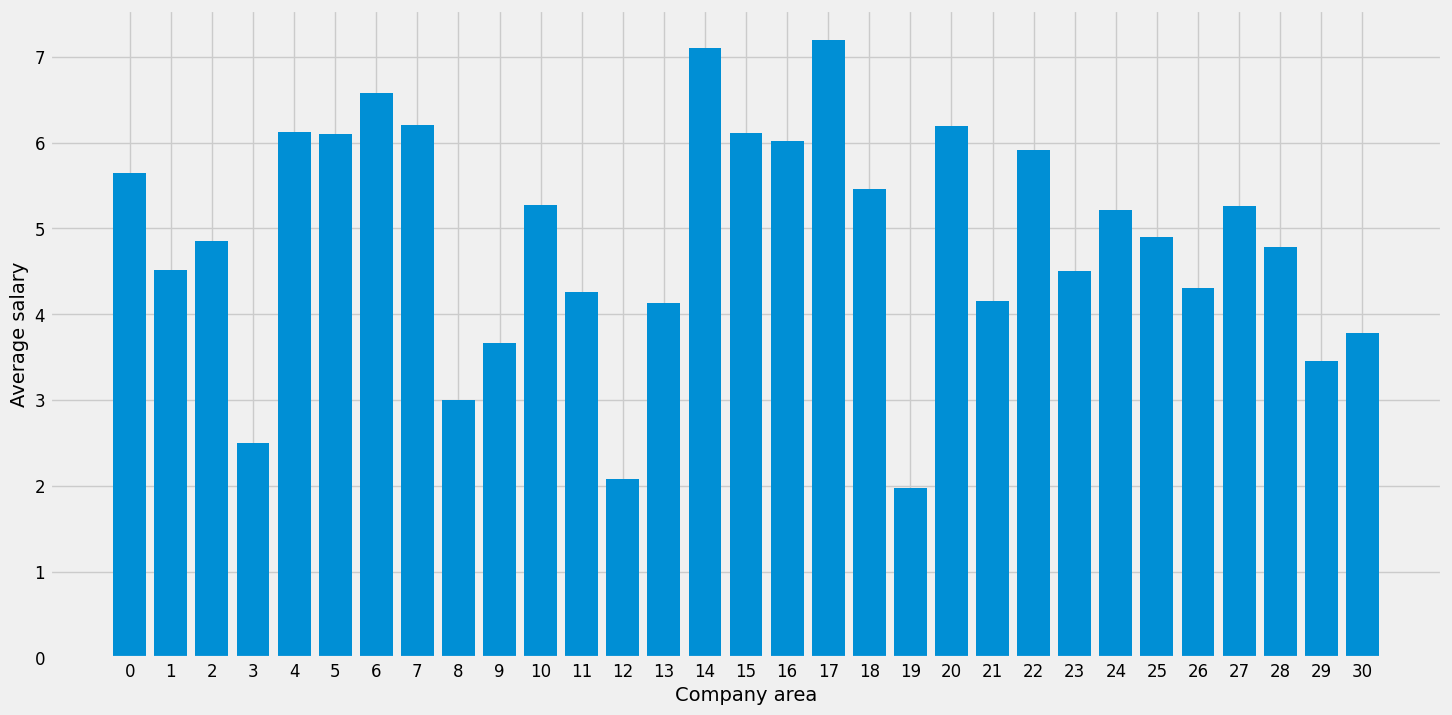

In [ ]:
values = np.sort(pd.unique(panda_comp_df["cnae_20_classe"]))
print("cnae_20_classe:", values)

x = []
y = []
for i, j in enumerate(values):
  tmp = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == j, ["vl_remun_media_sm"]]
  #x.append(str(j))
  x.append(str(i))
  y.append(tmp["vl_remun_media_sm"].median())

# plot

#plt.title("Average Salary By Company Area")
plt.xlabel("Company area")
plt.ylabel("Average salary")

plt.bar(x, y)

In [ ]:
tmp1 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[17], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[3], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"17 ==  3: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[17], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[12], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"17 == 12: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[0], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[13], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"0  == 13: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[0], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[21], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"0  == 21: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[9], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[3], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"9  ==  3: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[9], ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[panda_comp_df["cnae_20_classe"] == values[8], ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"9  ==  8: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

17 ==  3: [statistic=14.0, pvalue=0.11428571428571428]
17 == 12: [statistic=49.0, pvalue=0.002045143188017965]
0  == 13: [statistic=342.0, pvalue=0.09070718175969213]
0  == 21: [statistic=35981.0, pvalue=5.4616270372427085e-14]
9  ==  3: [statistic=13.0, pvalue=0.2]
9  ==  8: [statistic=16.0, pvalue=0.02857142857142857]


#### Nível de escolaridade

escolaridade_apos_2005: [6, 7, 8, 9, 10, 11]


<BarContainer object of 6 artists>

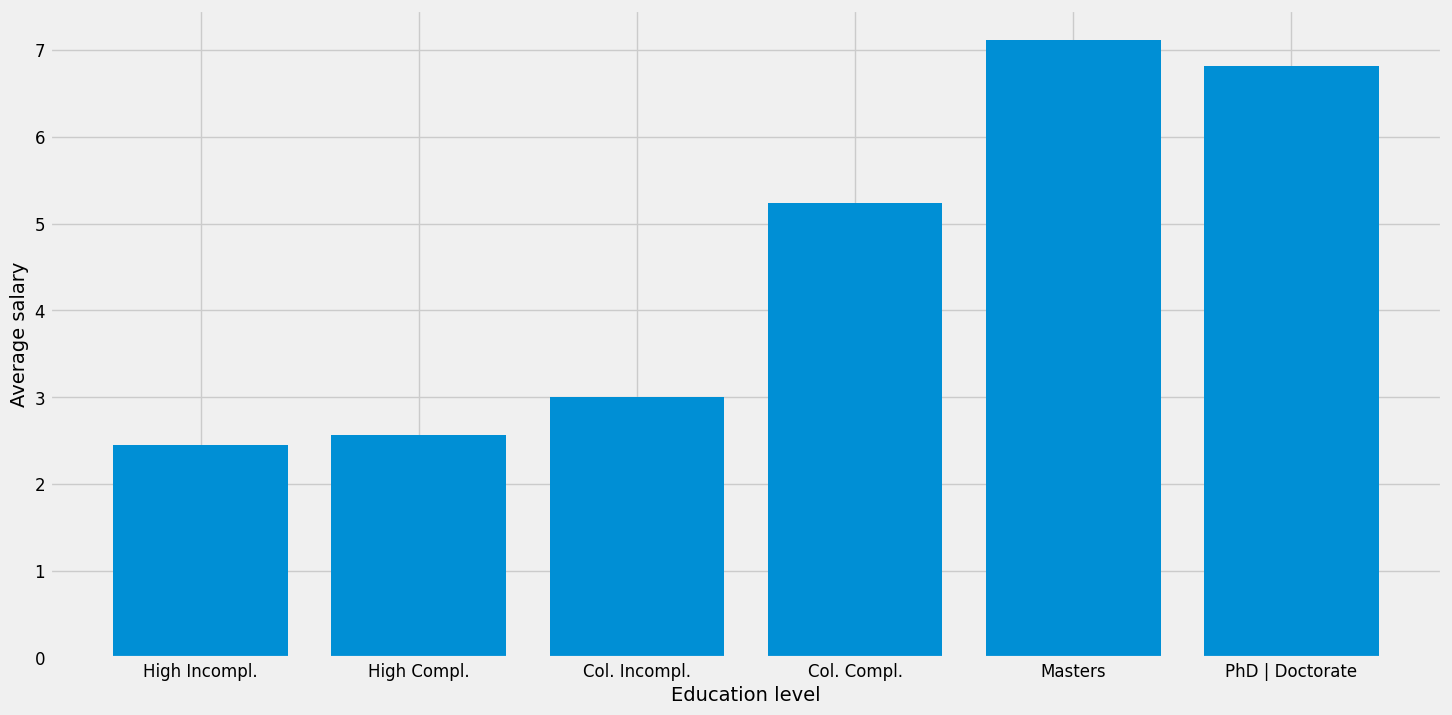

In [ ]:
values = [6, 7, 8, 9, 10, 11]
print("escolaridade_apos_2005:", values)

x = ["High Incompl.", "High Compl.", "Col. Incompl.", "Col. Compl.", "Masters", "PhD | Doctorate"]
y = []
for i in values:
  tmp = panda_comp_df.loc[panda_comp_df["escolaridade_apos_2005"] == i, ["vl_remun_media_sm"]]
  y.append(tmp["vl_remun_media_sm"].median())

# plot

#plt.title("Average Salary By Education Level")
plt.xlabel("Education level")
plt.ylabel("Average salary")

plt.bar(x, y)

In [ ]:
tmp1 = panda_comp_df.loc[((panda_comp_df["escolaridade_apos_2005"] == values[3]) | (panda_comp_df["escolaridade_apos_2005"] == values[4]) | (panda_comp_df["escolaridade_apos_2005"] == values[5])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["escolaridade_apos_2005"] == values[0]) | (panda_comp_df["escolaridade_apos_2005"] == values[1]) | (panda_comp_df["escolaridade_apos_2005"] == values[2])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"Masters+ == College-: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["escolaridade_apos_2005"] == values[4])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["escolaridade_apos_2005"] == values[3])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"Masters == College: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["escolaridade_apos_2005"] == values[3])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["escolaridade_apos_2005"] == values[2])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"College == High School: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

Masters+ == College-: [statistic=385488359.5, pvalue=0.0]
Masters == College: [statistic=208581.0, pvalue=8.700148565356382e-23]
College == High School: [statistic=116361099.5, pvalue=0.0]


#### Faixa etária

faixa_etaria: [5 3 7 6 4 8 2]


<BarContainer object of 7 artists>

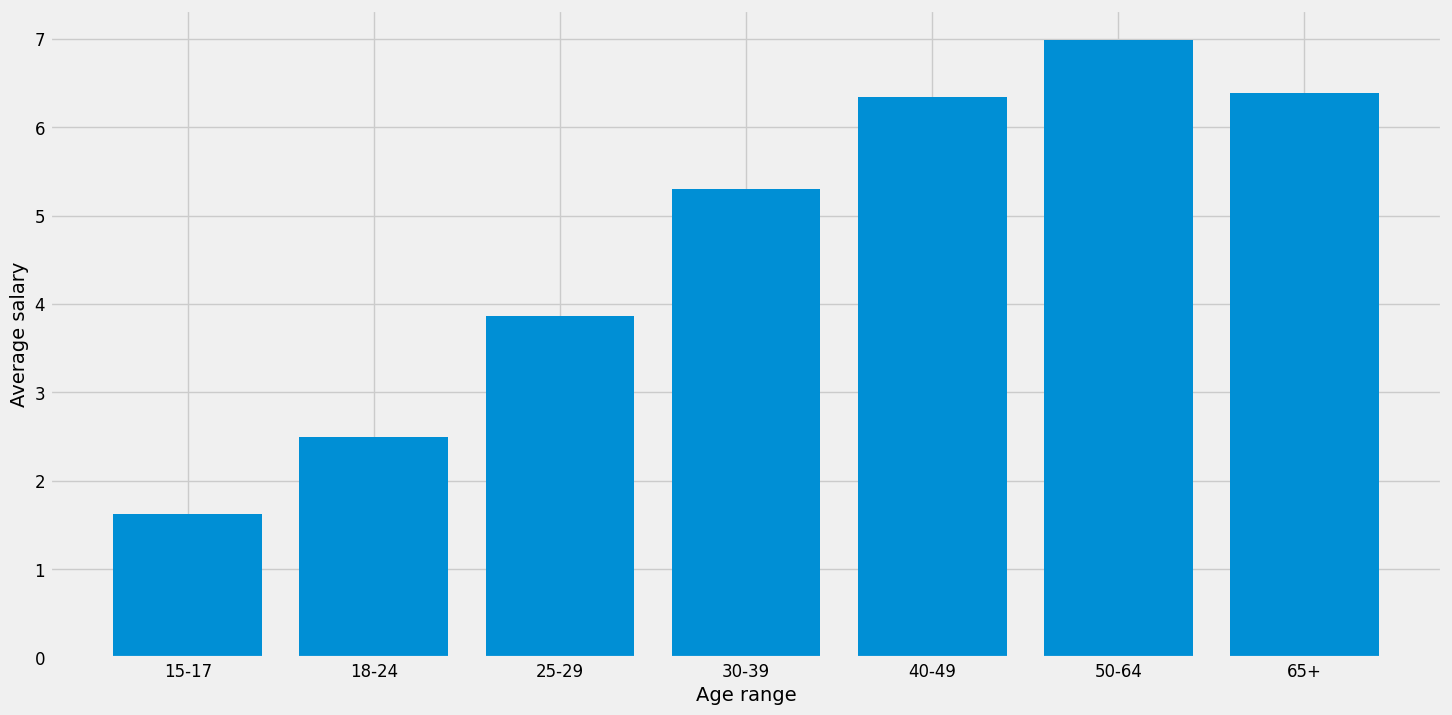

In [ ]:
values = [2, 3, 4, 5, 6, 7, 8]
print("faixa_etaria:", pd.unique(panda_comp_df["faixa_etaria"]))

x = ["15-17", "18-24", "25-29", "30-39", "40-49", "50-64", "65+"]
y = []
for i in values:
  tmp = panda_comp_df.loc[panda_comp_df["faixa_etaria"] == i, ["vl_remun_media_sm"]]
  y.append(tmp["vl_remun_media_sm"].median())

# plot

#plt.title("Average Salary By Age range")
plt.xlabel("Age range")
plt.ylabel("Average salary")

plt.bar(x, y)

In [ ]:
tmp1 = panda_comp_df.loc[((panda_comp_df["faixa_etaria"] == values[4]) | (panda_comp_df["faixa_etaria"] == values[5]) | (panda_comp_df["faixa_etaria"] == values[6])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["faixa_etaria"] == values[0]) | (panda_comp_df["faixa_etaria"] == values[1]) | (panda_comp_df["faixa_etaria"] == values[2]) | (panda_comp_df["faixa_etaria"] == values[3])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"40+ == 39-: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["faixa_etaria"] == values[4])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["faixa_etaria"] == values[2])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"40-49 == 25-29: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["faixa_etaria"] == values[5])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["faixa_etaria"] == values[4])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"50-64 == 40-49: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

40+ == 39-: [statistic=264942423.5, pvalue=0.0]
40-49 == 25-29: [statistic=142423120.0, pvalue=0.0]
50-64 == 40-49: [statistic=17405969.0, pvalue=1.5617556466084556e-52]


#### Carga horária semanal

faixa_hora_contrat: [ 5  6 99  3  1  4  2]


<BarContainer object of 6 artists>

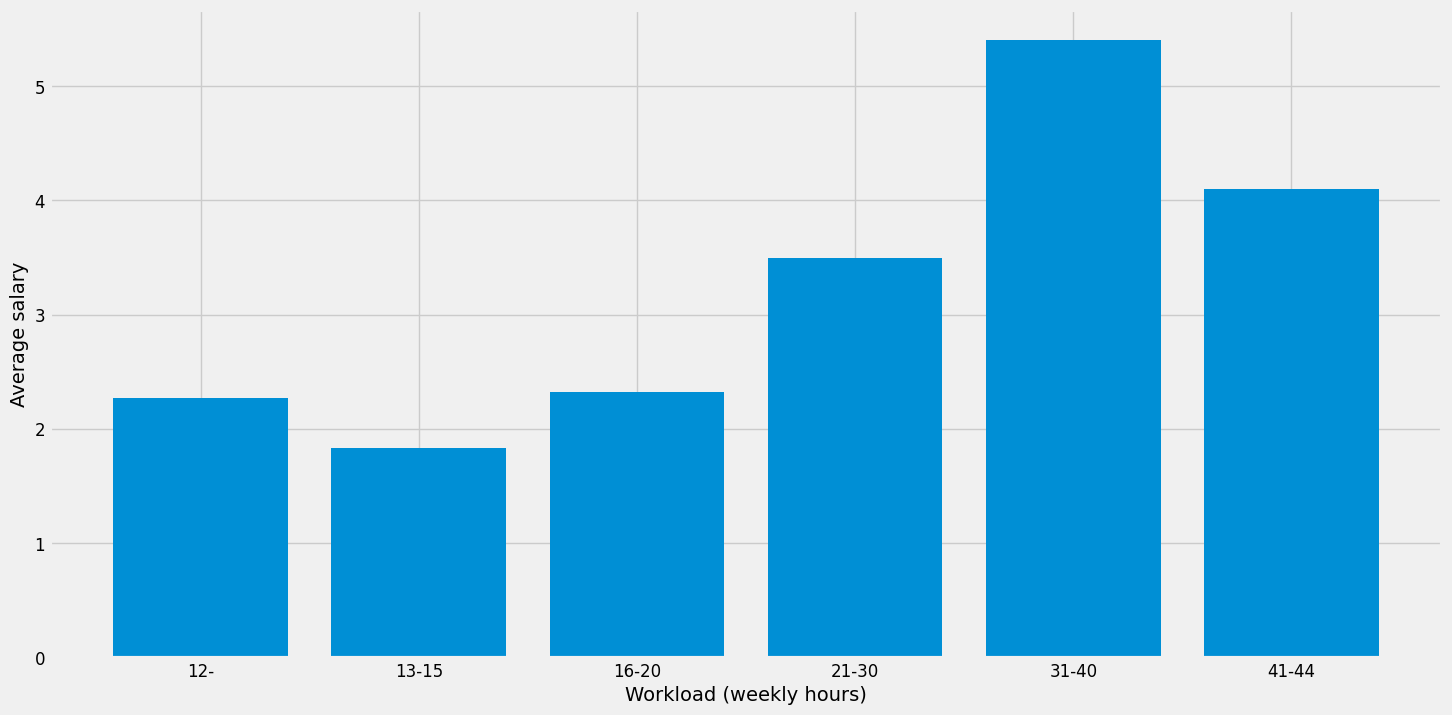

In [ ]:
values = [1, 2, 3, 4, 5, 6]
print("faixa_hora_contrat:", pd.unique(panda_comp_df["faixa_hora_contrat"]))

x = ["12-", "13-15", "16-20", "21-30", "31-40", "41-44"]
y = []
for i in values:
  tmp = panda_comp_df.loc[panda_comp_df["faixa_hora_contrat"] == i, ["vl_remun_media_sm"]]
  y.append(tmp["vl_remun_media_sm"].median())

# plot

#plt.title("Average Salary By Weekly Workload")
plt.xlabel("Workload (weekly hours)")
plt.ylabel("Average salary")

plt.bar(x, y)

In [ ]:
tmp1 = panda_comp_df.loc[((panda_comp_df["faixa_hora_contrat"] == values[3]) | (panda_comp_df["faixa_hora_contrat"] == values[4]) | (panda_comp_df["faixa_hora_contrat"] == values[5]) | (panda_comp_df["faixa_hora_contrat"] == 99)), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["faixa_hora_contrat"] == values[0]) | (panda_comp_df["faixa_hora_contrat"] == values[1]) | (panda_comp_df["faixa_hora_contrat"] == values[2])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"21+ == 20-: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["faixa_hora_contrat"] == values[4]) | (panda_comp_df["faixa_hora_contrat"] == 99)), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["faixa_hora_contrat"] == values[3])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"31-40 == 21-30: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["faixa_hora_contrat"] == values[4]) | (panda_comp_df["faixa_hora_contrat"] == 99)), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["faixa_hora_contrat"] == values[2])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"31-40 == 16-20: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

21+ == 20-: [statistic=7313.5, pvalue=5.515428710231318e-07]
31-40 == 21-30: [statistic=27422.5, pvalue=0.0008239930097682177]
31-40 == 16-20: [statistic=993.0, pvalue=0.020413743916744134]


#### Tamanho da empresa

tamanho_estabelecimento: [ 7  4  6  5  1  3  2  8 10  9]


<BarContainer object of 10 artists>

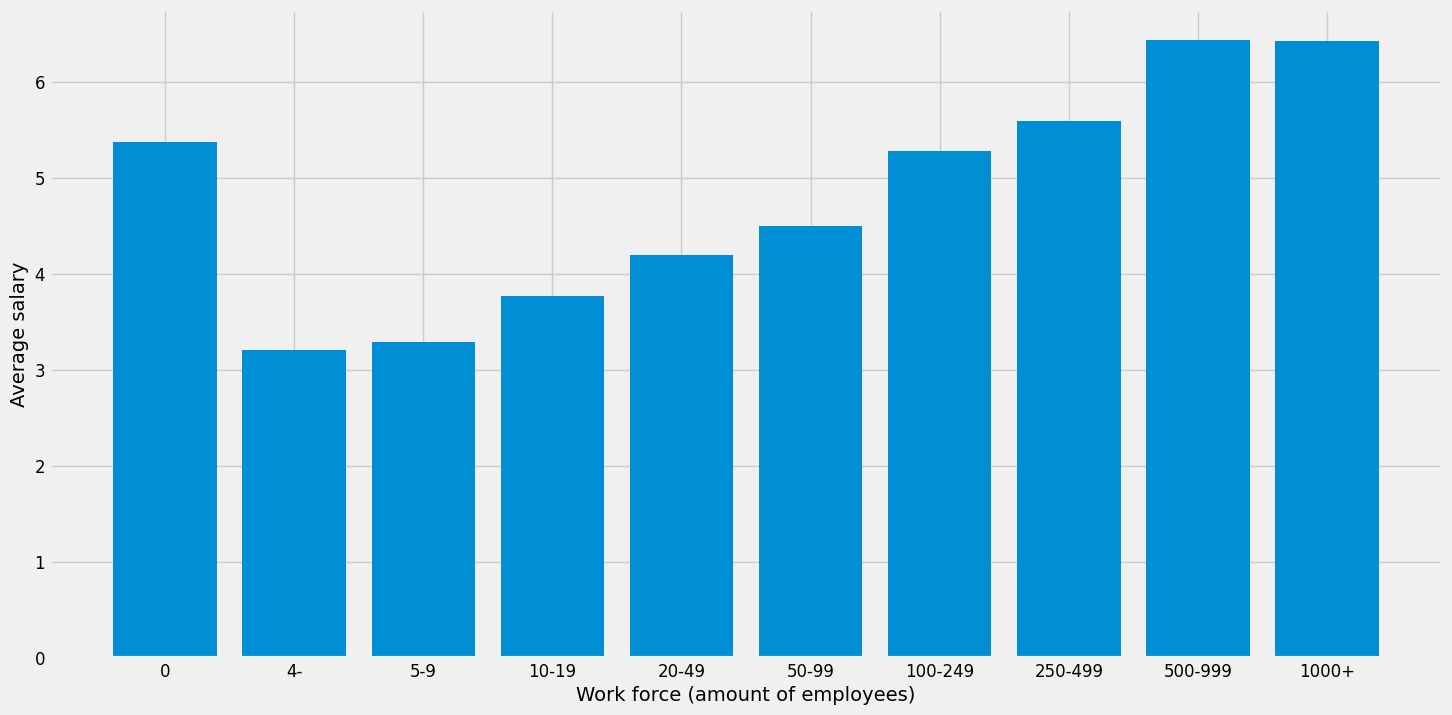

In [ ]:
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print("tamanho_estabelecimento:", pd.unique(panda_comp_df["tamanho_estabelecimento"]))

x = ["0", "4-", "5-9", "10-19", "20-49", "50-99", "100-249", "250-499", "500-999", "1000+"]
y = []
for i in values:
  tmp = panda_comp_df.loc[panda_comp_df["tamanho_estabelecimento"] == i, ["vl_remun_media_sm"]]
  y.append(tmp["vl_remun_media_sm"].median())

# plot

#plt.title("Average Salary By Company Size")
plt.xlabel("Work force (amount of employees)")
plt.ylabel("Average salary")

plt.bar(x, y)

In [ ]:
tmp1 = panda_comp_df.loc[((panda_comp_df["tamanho_estabelecimento"] == values[0]) | (panda_comp_df["tamanho_estabelecimento"] == values[7]) | (panda_comp_df["tamanho_estabelecimento"] == values[8]) | (panda_comp_df["tamanho_estabelecimento"] == values[9])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["tamanho_estabelecimento"] == values[1]) | (panda_comp_df["tamanho_estabelecimento"] == values[2]) | (panda_comp_df["tamanho_estabelecimento"] == values[3]) | (panda_comp_df["tamanho_estabelecimento"] == values[4]) | (panda_comp_df["tamanho_estabelecimento"] == values[5]) | (panda_comp_df["tamanho_estabelecimento"] == values[6])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"0 or 250+ == 1-249: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["tamanho_estabelecimento"] == values[8])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["tamanho_estabelecimento"] == values[7])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"500-999 == 250-499: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

tmp1 = panda_comp_df.loc[((panda_comp_df["tamanho_estabelecimento"] == values[7])), ["vl_remun_media_sm"]]
tmp2 = panda_comp_df.loc[((panda_comp_df["tamanho_estabelecimento"] == values[6])), ["vl_remun_media_sm"]]
smaller_size = len(tmp1) if len(tmp1) < len(tmp2) else len(tmp2)
res = stats.mannwhitneyu(x=tmp1[: smaller_size - 1], y=tmp2[: smaller_size - 1], alternative="two-sided")
print(f"500-999 == 250-499: [statistic={res.statistic[0]}, pvalue={res.pvalue[0]}]")

0 or 250+ == 1-249: [statistic=905620232.5, pvalue=0.0]
500-999 == 250-499: [statistic=38279111.5, pvalue=6.216230564489447e-25]
500-999 == 250-499: [statistic=61481152.0, pvalue=2.0793426652028542e-08]


In [ ]:
len(panda_comp_df)

76901

# Modelos

## Métodos gerais

In [ ]:
def dimentions(x: int) -> tuple:
  """Generate best dimentions prioritizing more columns for graph subplots."""
  result = None
  # if x is perfect square, get perfect square
  sqx = float((x ** (1/2)))
  if sqx - int(sqx) == 0.0:
    result = (int(sqx), int(sqx))
  else:
    # rows
    for i in range(1, int(x / 2) + 1):
      # columns
      for j in range(i, int(x / 2) + 1):
        if i * j >= x:
          result = (i, j)
          break
  return result

In [ ]:
def multiple_confusion_matrix(X_test, y_test, models: tuple) -> None:
  for cls in models:
    y_pred = cls.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[i for i in range(3, 10)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(3, 10)])
    disp.plot()

In [ ]:
def make_report(y_true, y_pred, complete_report=True, inline=False):
  """Abstraction of classification_report. It returns a complete report
  if complete_report=True, only general accuracy if False."""

  # yt = np.array([int(x) for x in y_true])
  # yp = np.array([int(x) for x in y_pred])

  if inline:
    print(classification_report(y_true, y_pred))
  else:
    result = classification_report(y_true, y_pred, output_dict=True)
    return result if complete_report else result["accuracy"]

## Modelos de classificação


Principais colunas para se considerar para o modelo de classificação

*   CBO
*   CNAE
*   Município*
*   Município de trabalho*
*   Faixa etária
*   Escolaridade
*   Quantidade de horas contratadas
*   Idade
*   Raça
*   Sexo
*   Tamanho do estabelecimento
*   Tipo de estabelecimento
*   Tipo de deficiência
*   **Faixa de remuneração média (saída)**

\* Analisar distância entre municípios

### Preparos gerais

#### Dados gerais

In [ ]:
# all salary related columns that aren't Y + columns that give
# non-ascii characters related errors

cols_for_pred = ['cbo_ocupacao_2002', 'cnae_20_classe',
 'faixa_remun_media_sm', 'escolaridade_apos_2005',
 'qtd_hora_contr', 'idade', 'mun_trab', 'raca_cor',
 'cnae_20_subclasse', 'sexo_trabalhador',
 'tamanho_estabelecimento', 'tempo_emprego', 'tipo_defic']

cols_to_drop = (
    "faixa_remun_dezem_sm",
    "vl_remun_dezembro_nom", "vl_remun_media_nom",
    "vl_remun_dezembro_sm",
    "vl_rem_janeiro_cc", "vl_rem_fevereiro_cc", "vl_rem_marco_cc",
    "vl_rem_abril_cc", "vl_rem_maio_cc", "vl_rem_junho_cc",
    "vl_rem_julho_cc", "vl_rem_agosto_cc", "vl_rem_setembro_cc",
    "vl_rem_outubro_cc", "vl_rem_novembro_cc",
    "tipo_estab2",
    "area_atuacao_cnae", "area_atuacao_cbo",
    "regioes_adm_df", "bairros_sp", "distritos_sp",
    "mes_desligamento",
    "cnae_95_classe", "novas_faixas_salariais",
)

cols_for_pred_most = []

for col in comp_df.columns:
  if col not in cols_to_drop:
    cols_for_pred_most.append(col)

# remove outliers by segregation based on boxplots generated in the beggining

classification_comp_df = comp_df.drop(*cols_to_drop)

classification_comp_df.columns

['causa_afastamento_1',
 'causa_afastamento_2',
 'causa_afastamento_3',
 'Motivo_Desligamento',
 'cbo_ocupacao_2002',
 'cnae_20_classe',
 'vinculo_ativo_31_12',
 'faixa_etaria',
 'faixa_hora_contrat',
 'faixa_remun_media_sm',
 'faixa_tempo_emprego',
 'escolaridade_apos_2005',
 'qtd_hora_contr',
 'idade',
 'ind_cei_vinculado',
 'ind_simples',
 'mes_admissao',
 'mun_trab',
 'municipio',
 'nacionalidade',
 'natureza_juridica',
 'ind_portador_defic',
 'qtd_dias_afastamento',
 'raca_cor',
 'vl_remun_media_sm',
 'cnae_20_subclasse',
 'sexo_trabalhador',
 'tamanho_estabelecimento',
 'tempo_emprego',
 'tipo_admissao',
 'tipo_estab1',
 'tipo_defic',
 'tipo_vinculo',
 'ibge_subsetor',
 'ano_chegada_brasil',
 'ind_trab_intermitente',
 'ind_trab_parcial']

#### Dados em pandas

In [ ]:
panda_comp_df = classification_comp_df.toPandas()

In [ ]:
for c in panda_comp_df.columns.tolist():
  panda_comp_df[c] = pd.to_numeric(panda_comp_df[c])

In [ ]:
panda_comp_df = panda_comp_df[panda_comp_df["faixa_remun_media_sm"] > 2]

#### Preparo de hiper-parâmetros

In [ ]:
# General

random_state = 5
train_size = 0.8

# RandomForest

tol = 1e-4
n_estimators = 130
max_depth = 15
criterion = "entropy"

# LogisticRegressor

max_iter = 1500

### Pré-processamento dos dados

#### Normalizar quantidades de cada classe

In [ ]:
print("Before limiting\n")
for i in range(0, 11):
  print(f"Class {i}\n")
  print(len(panda_comp_df.loc[panda_comp_df["faixa_remun_media_sm"] == i]["faixa_remun_media_sm"]))

panda_comp_df_filtered = panda_comp_df.groupby("faixa_remun_media_sm").head(5749)

print("\n\n\n")
print("After limiting\n")
for i in range(0, 11):
  print(f"Class {i}\n")
  print(len(panda_comp_df_filtered.loc[panda_comp_df_filtered["faixa_remun_media_sm"] == i]["faixa_remun_media_sm"]))

Before limiting

Class 0

0
Class 1

0
Class 2

0
Class 3

5749
Class 4

10632
Class 5

10068
Class 6

8665
Class 7

15896
Class 8

17863
Class 9

7275
Class 10

0




After limiting

Class 0

0
Class 1

0
Class 2

0
Class 3

5749
Class 4

5749
Class 5

5749
Class 6

5749
Class 7

5749
Class 8

5749
Class 9

5749
Class 10

0


#### Normalização de dados

In [ ]:
# define categorical columns
non_categorical_cols = [
    "idade", "ano_chegada_brasil", "qtd_dias_afastamento",
    "cnae_20_subclasse", "cnae_20_classe", "cbo_ocupacao_2002",
    "faixa_remun_media_sm"# , "novas_faixas_salariais" # Y
]
cat_columns = []
for col in panda_comp_df_filtered.columns:
  if col not in non_categorical_cols:
    cat_columns.append(col)
    #panda_comp_df_filtered[col] = panda_comp_df_filtered[col].astype("category")

# set encoded/normalized data

catboost_scaler = CatBoostEncoder(cols=cat_columns, handle_missing='return_nan', handle_unknown='return_nan')

y = panda_comp_df_filtered["faixa_remun_media_sm"].astype(int)
df_no_y = panda_comp_df_filtered.drop(["faixa_remun_media_sm"], axis=1)

catboost_scaler.fit(df_no_y, y)
df_cat_boost = catboost_scaler.transform(df_no_y)
df_cat_boost.columns = df_no_y.columns

df_cat_boost = df_cat_boost.drop("vl_remun_media_sm", axis=1)

print(len(y))

53777



General score: 0.400.
5-fold: [0.369, 0.366, 0.353, 0.357, 0.363]
Mean: 0.362, Std: 0.006



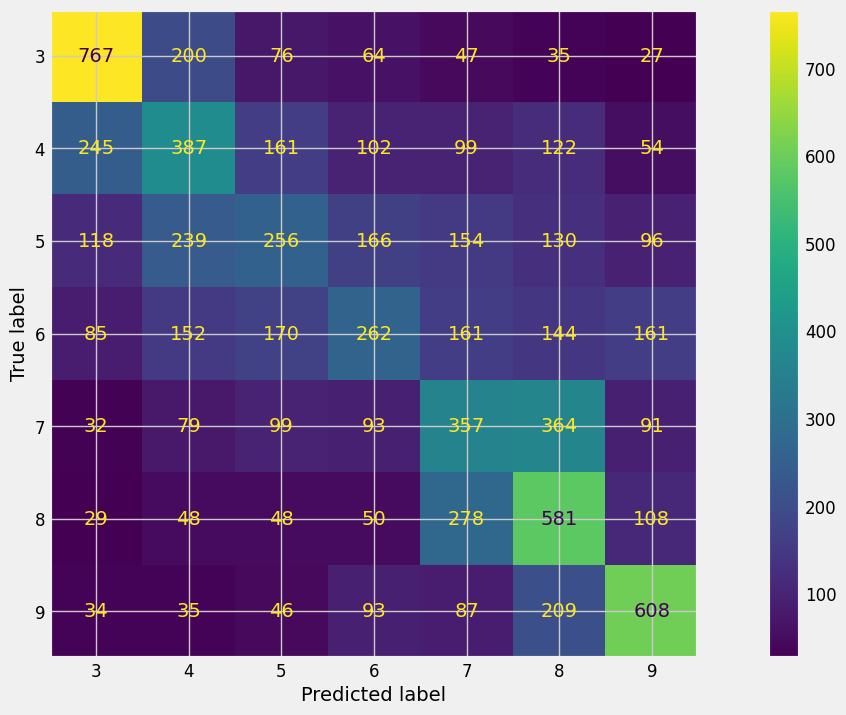

In [ ]:
from sklearn.model_selection import cross_val_score

y = panda_comp_df_filtered["faixa_remun_media_sm"].astype(int)
df_no_y = panda_comp_df_filtered.drop(["faixa_remun_media_sm", "vl_remun_media_sm"], axis=1)

X = df_no_y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

model = RandomForestClassifier(n_estimators=128, max_depth=20, random_state=random_state, criterion=criterion)
model.fit(X_train, y_train)

print(f"\nGeneral score: %.3f." % (model.score(X_test, y_test)))

cross_val = cross_val_score(model, X_test, y_test)
mean, std = cross_val.mean(), cross_val.std()
cross_values = [float(('%.3f'%(i))) for i in cross_val]
print("5-fold:", cross_values)
print("Mean: %.3f, Std: %.3f\n" % (mean, std))

multiple_confusion_matrix(X_test, y_test, (model,))

In [ ]:
cols_for_pred_objective = ["cbo_ocupacao_2002", "cnae_20_subclasse",
                           "cnae_20_classe", "mun_trab", "qtd_hora_contr",
                           "tempo_emprego", "escolaridade_apos_2005",
                           "faixa_remun_media_sm"]

cols_to_drop_objective = []

for col in panda_comp_df_filtered.columns:
  if col not in cols_for_pred_objective:
    cols_to_drop_objective.append(col)

panda_comp_df_objective = panda_comp_df_filtered.drop(cols_to_drop_objective, axis=1)

y_objective = panda_comp_df_objective["faixa_remun_media_sm"].astype(int)
df_no_y_objective = panda_comp_df_objective.drop(["faixa_remun_media_sm"], axis=1)

#### Dados de treino

In [ ]:
X = df_no_y_objective.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_objective, train_size=train_size, random_state=random_state)

### Testes básicos

#### LinearSVC

In [ ]:
model = LinearSVC(penalty='l1', dual=False, random_state=random_state, tol=tol)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, penalty='l1', random_state=5)


Score: 0.31044642857142857.



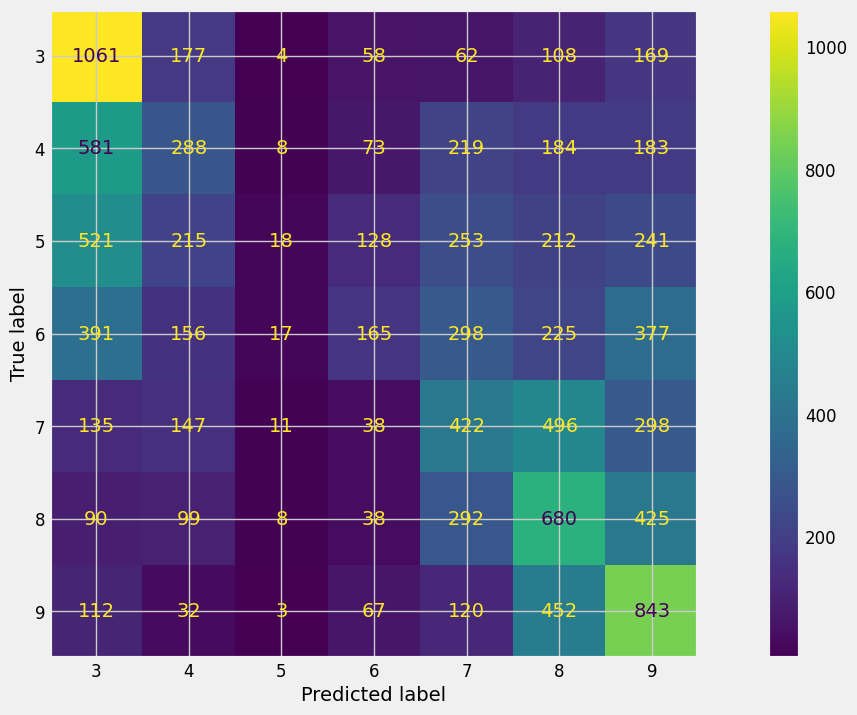

In [ ]:
pred_test = model.predict(X_test)
print(f"\nScore: {make_report(y_test, pred_test, complete_report=False)}.\n")
multiple_confusion_matrix(X_test, y_test, (model,))

#### RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=random_state, criterion=criterion)
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, random_state=5)


General score: 0.286.
5-fold: [0.249, 0.267, 0.249, 0.256, 0.274]
Mean: 0.259, Std: 0.010



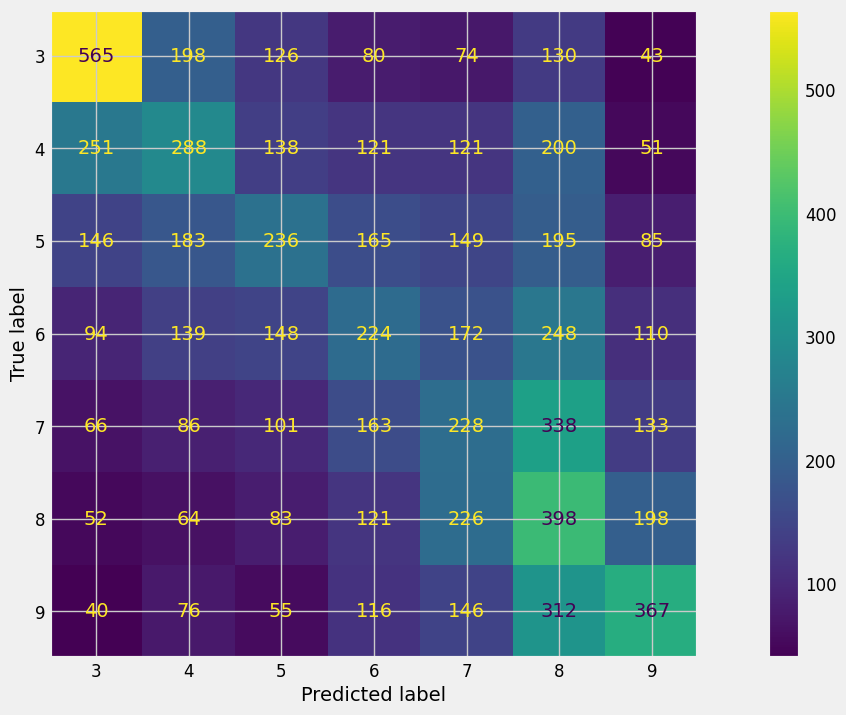

In [ ]:
print(f"\nGeneral score: %.3f." % (model.score(X_test, y_test)))

cross_val = cross_val_score(model, X_test, y_test)
mean, std = cross_val.mean(), cross_val.std()
cross_values = [float(('%.3f'%(i))) for i in cross_val]
print("5-fold:", cross_values)
print("Mean: %.3f, Std: %.3f\n" % (mean, std))

multiple_confusion_matrix(X_test, y_test, (model,))

<BarContainer object of 7 artists>

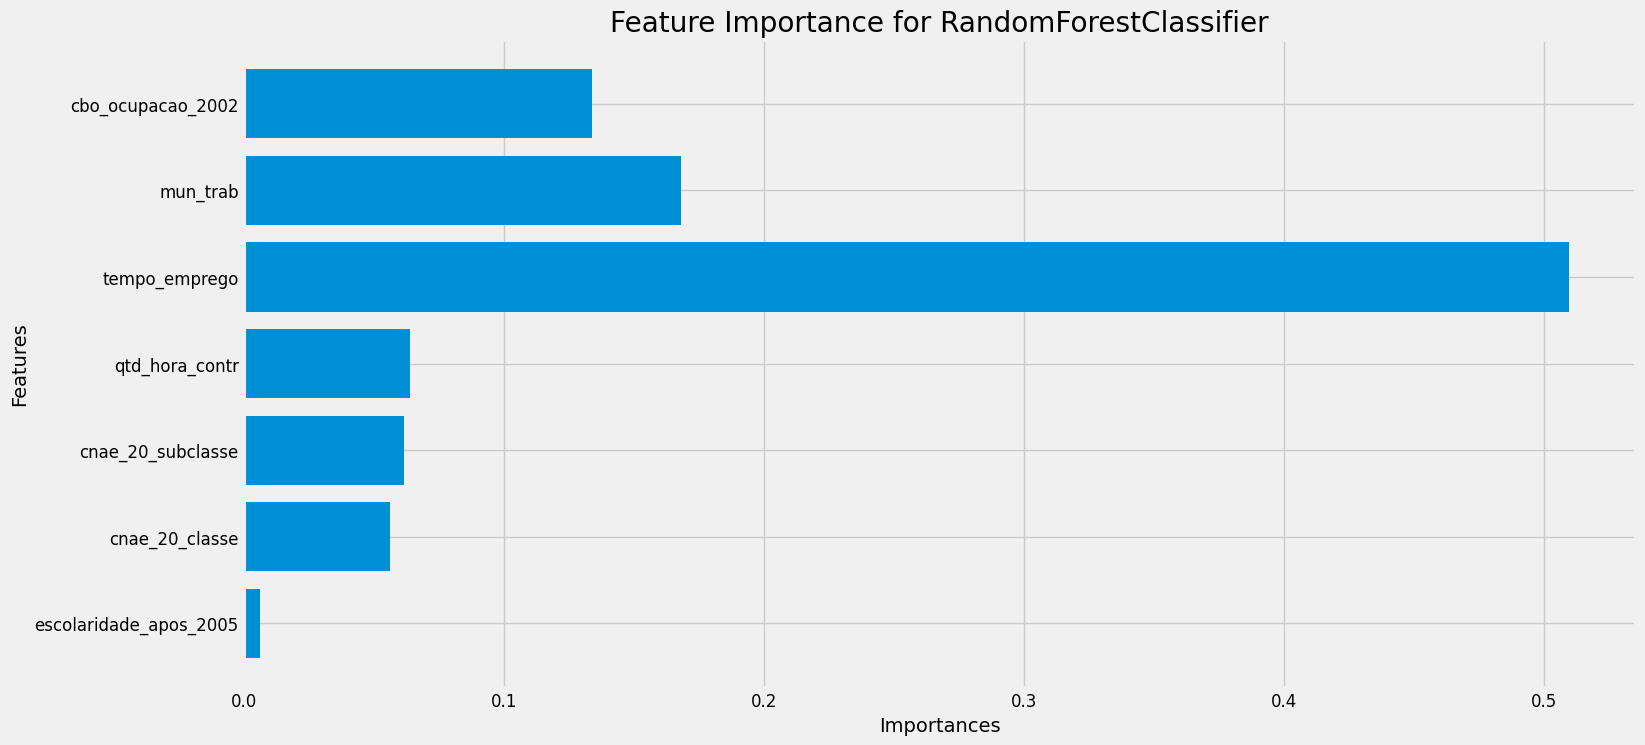

In [ ]:
# plot feature importances for random forest

plt.title("Feature Importance for RandomForestClassifier")

plt.xlabel("Importances")
plt.ylabel("Features")

perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(df_no_y_objective.columns[sorted_idx], model.feature_importances_[sorted_idx])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(model, X_test, y_test)
print("values:", cross_val)
print(f"mean: {cross_val.mean()}, std: {cross_val.std()}")

values: [0.24906832 0.26708075 0.24906832 0.25590062 0.27408328]
mean: 0.25904025879273807, std: 0.009996782379727098



General score: 0.222.
5-fold: [0.194, 0.188, 0.194, 0.202, 0.197]
Mean: 0.195, Std: 0.005



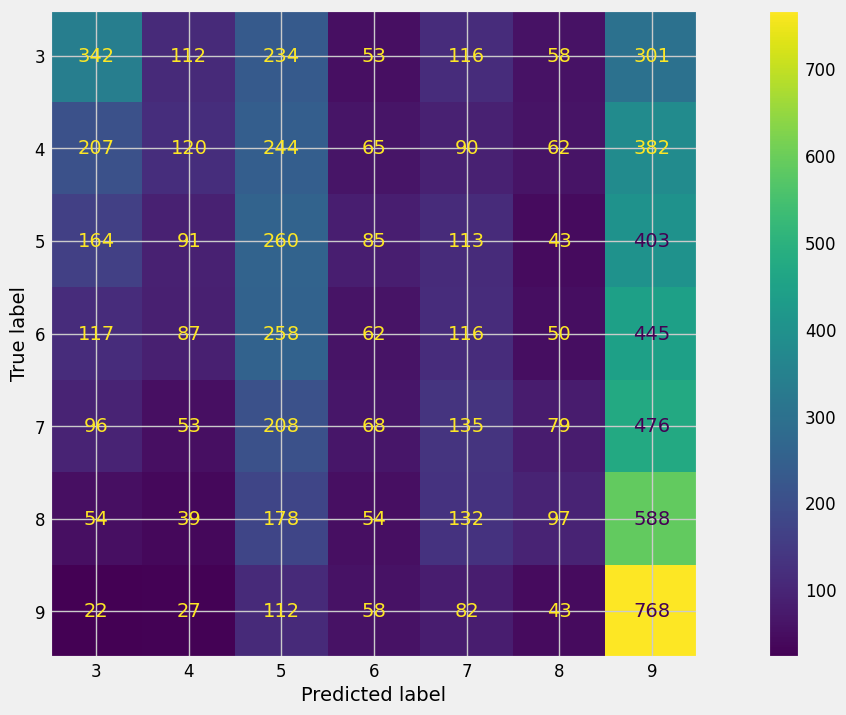

In [ ]:
cols_for_pred_social = ["sexo_trabalhador", "raca_cor", "tipo_defic", "idade", "faixa_remun_media_sm"]

cols_to_drop_social = []

for col in panda_comp_df_filtered.columns:
  if col not in cols_for_pred_social:
    cols_to_drop_social.append(col)

panda_comp_df_social = panda_comp_df_filtered.drop(cols_to_drop_social, axis=1)

y_social = panda_comp_df_social["faixa_remun_media_sm"].astype(int)
df_no_y_social = panda_comp_df_social.drop(["faixa_remun_media_sm"], axis=1)

X = df_no_y_social.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_social, train_size=train_size, random_state=random_state)

model = RandomForestClassifier(n_estimators=128, max_depth=20, random_state=random_state, criterion=criterion)
model.fit(X_train, y_train)

print(f"\nGeneral score: %.3f." % (model.score(X_test, y_test)))

cross_val = cross_val_score(model, X_test, y_test)
mean, std = cross_val.mean(), cross_val.std()
cross_values = [float(('%.3f'%(i))) for i in cross_val]
print("5-fold:", cross_values)
print("Mean: %.3f, Std: %.3f\n" % (mean, std))

multiple_confusion_matrix(X_test, y_test, (model,))

race: 1
indexes: Series([], Name: faixa_remun_media_sm, dtype: int64)
race: 2
indexes: 54692    3
6956     5
71918    3
73340    3
43031    5
        ..
10326    3
21238    5
74821    3
36064    3
48317    3
Name: faixa_remun_media_sm, Length: 2375, dtype: int64
race: 4
indexes: Series([], Name: faixa_remun_media_sm, dtype: int64)
race: 6
indexes: Series([], Name: faixa_remun_media_sm, dtype: int64)
race: 8
indexes: 12942    9
53567    9
34176    9
51895    9
1962     9
        ..
30363    9
54211    9
35532    9
59159    9
41573    9
Name: faixa_remun_media_sm, Length: 1112, dtype: int64
race: 9
indexes: Series([], Name: faixa_remun_media_sm, dtype: int64)
races: [1 2 4 6 8 9]
true mean: [nan, 3.976, nan, nan, 9.0, nan]


<BarContainer object of 4 artists>

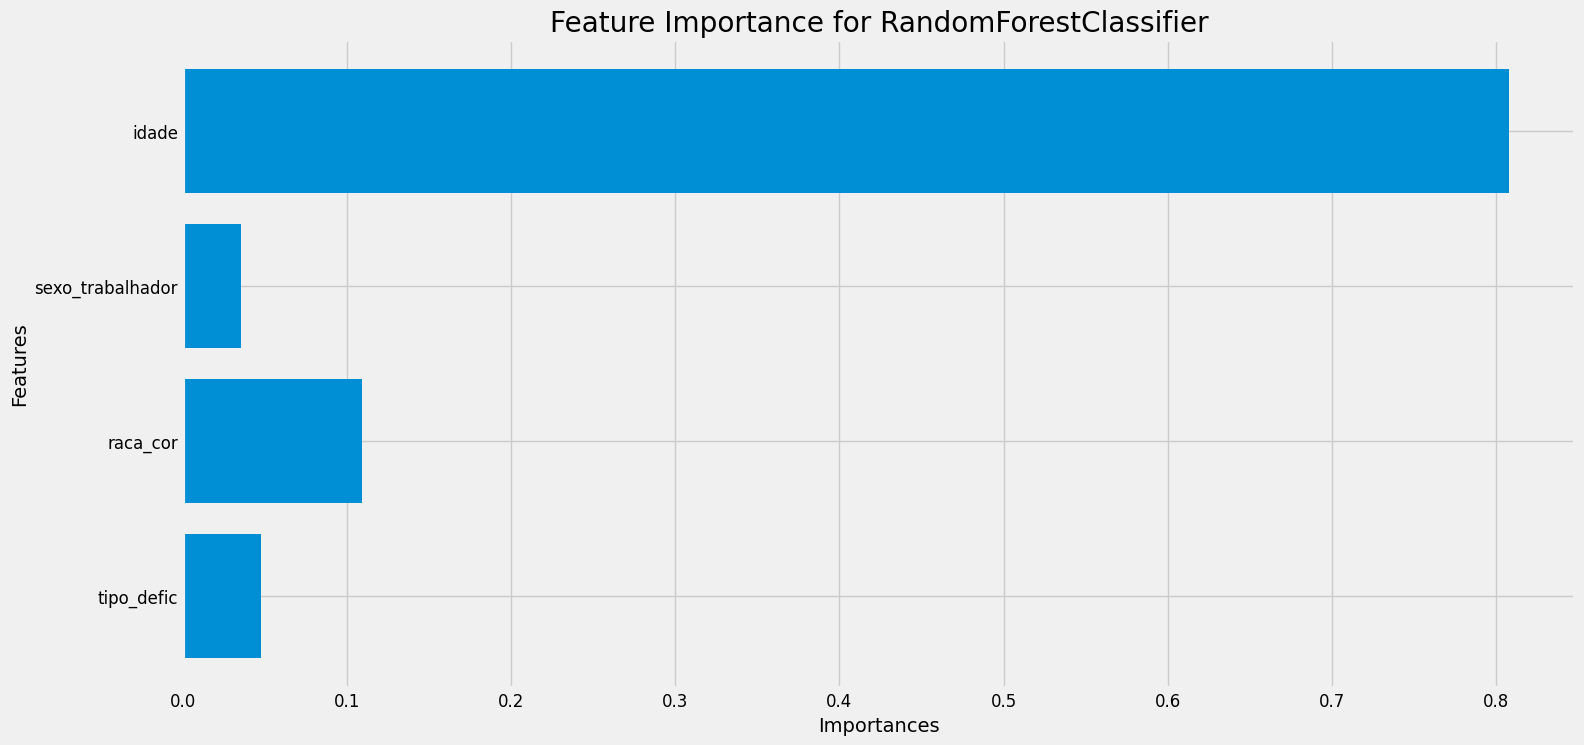

In [ ]:
# plot feature importances for random forest

plt.title("Feature Importance for RandomForestClassifier")

plt.xlabel("Importances")
plt.ylabel("Features")

perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(df_no_y_social.columns[sorted_idx], model.feature_importances_[sorted_idx])


Score: 0.25705843729481287.

values: [0.23013789 0.22816809 0.24097177 0.23440578 0.23670387]
mean: 0.2340774786605384, std: 0.004582100150326437


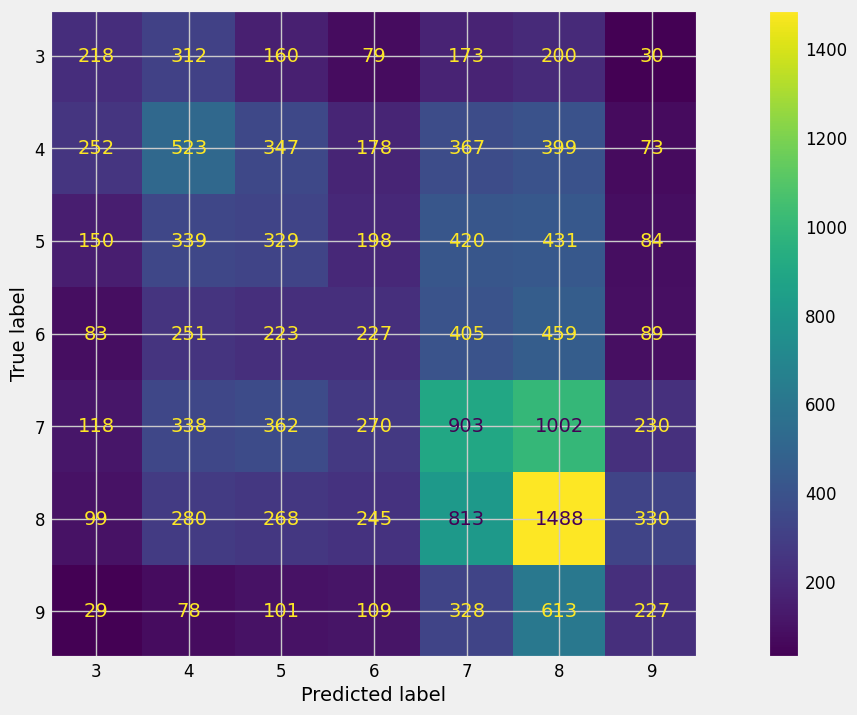

In [ ]:
cols_for_pred_mixed = [
    "cbo_ocupacao_2002",
    "tempo_emprego",
    "escolaridade_apos_2005", "qtd_hora_contr",
    "raca_cor", "sexo_trabalhador", "idade",
    "faixa_remun_media_sm"
]

cols_to_drop_mixed = []

for col in panda_comp_df_filtered.columns:
  if col not in cols_for_pred_mixed:
    cols_to_drop_mixed.append(col)

panda_comp_df_mixed = panda_comp_df_filtered.drop(cols_to_drop_mixed, axis=1)

y_mixed = panda_comp_df_mixed["faixa_remun_media_sm"].astype(int)
df_no_y_mixed = panda_comp_df_mixed.drop(["faixa_remun_media_sm"], axis=1)

X = df_no_y_mixed.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_mixed, train_size=train_size, random_state=random_state)

model = RandomForestClassifier(n_estimators=128, max_depth=30, criterion=criterion)
model.fit(X_train, y_train)

print(f"\nScore: {model.score(X_test, y_test)}.\n")

cross_val = cross_val_score(model, X_test, y_test)
print("values:", cross_val)
print(f"mean: {cross_val.mean()}, std: {cross_val.std()}")

multiple_confusion_matrix(X_test, y_test, (model,))

#### LogisticRegressor

In [ ]:
model = LogisticRegression(random_state=random_state, max_iter=max_iter)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1500, random_state=5)


Score: 0.16080357142857143.



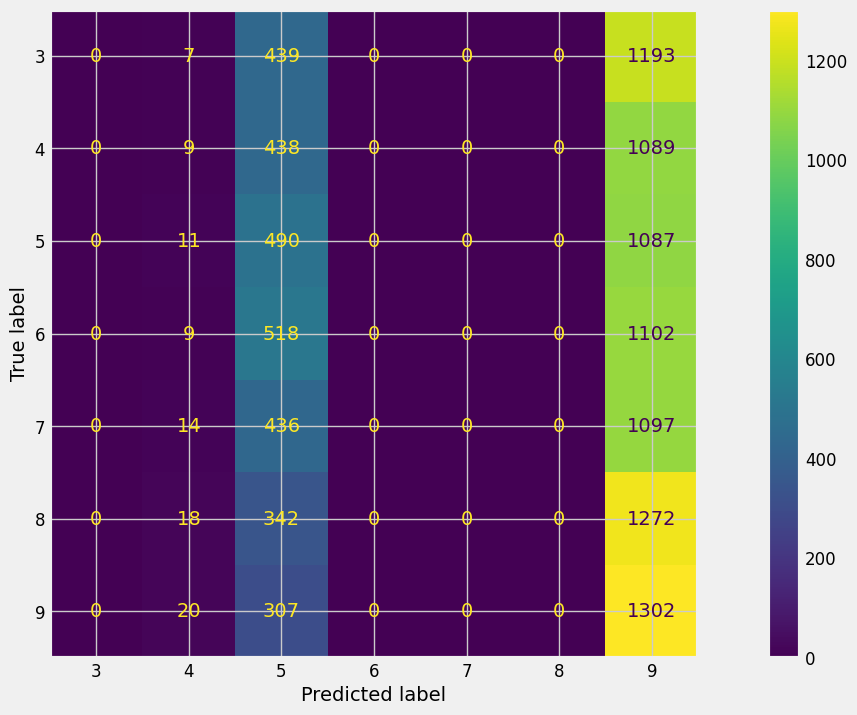

In [ ]:
print(f"\nScore: {model.score(X_test, y_test)}.\n")
multiple_confusion_matrix(X_test, y_test, (model,))

#### DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier(random_state=random_state, criterion=criterion)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=5)


Score: 0.3250892857142857.



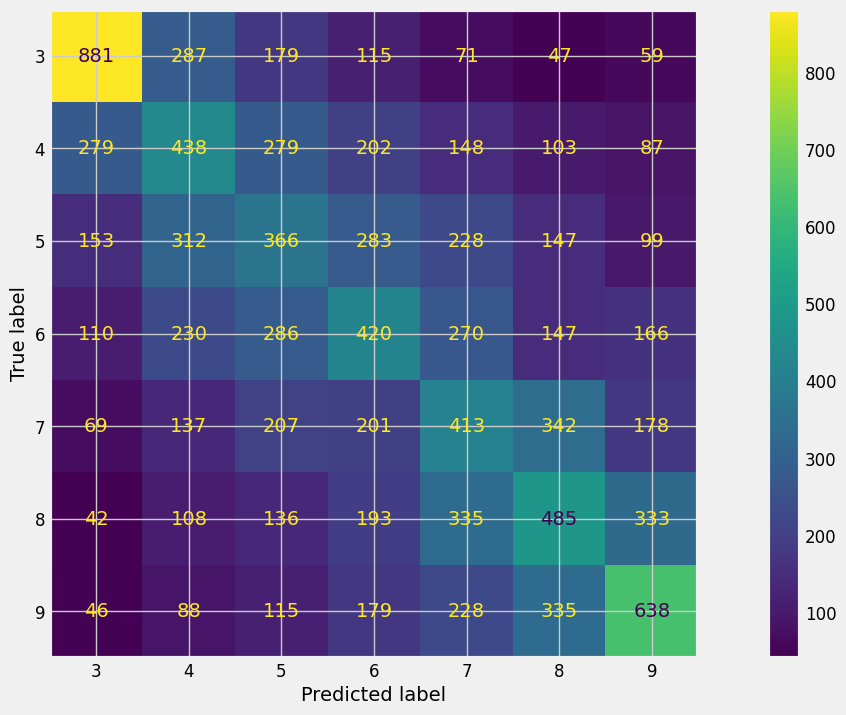

In [ ]:
print(f"\nScore: {model.score(X_test, y_test)}.\n")
multiple_confusion_matrix(X_test, y_test, (model,))

#### GradientTreeBoosting

In [ ]:
model = GradientBoostingClassifier(n_estimators=124, max_depth=15, n_iter_no_change=10)
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=15, n_estimators=124, n_iter_no_change=10)


Score: 0.3716964285714286.



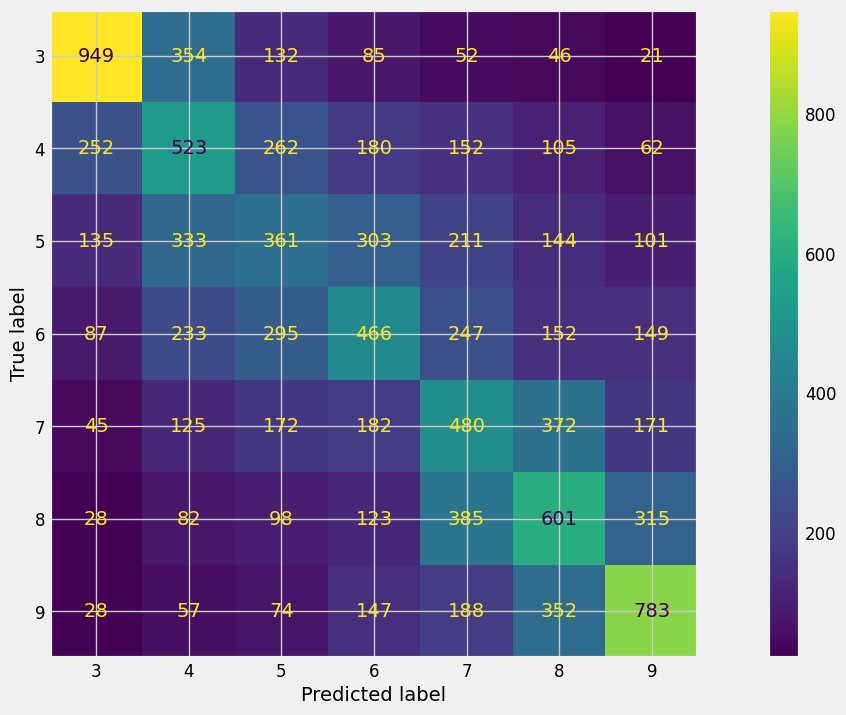

In [ ]:
print(f"\nScore: {model.score(X_test, y_test)}.\n")
multiple_confusion_matrix(X_test, y_test, (model,))

### Deep Learning

In [ ]:
# Basic imports.
import os, sys, time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.backends import cudnn
cudnn.benchmark = True

from torch.utils.data import Dataset, DataLoader
from torch.utils import data

from torchvision import datasets

from torchvision import transforms

from skimage import io

from sklearn import metrics

In [ ]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [ ]:
# Setting predefined arguments.
args = {
    'num_epochs': 2000,      # Number of epochs.
    'num_classes': 12,     # Number of classes.
    'lr': 1e-5,            # Learning rate.
    'weight_decay': 5e-4,  # L2 penalty.
    'num_workers': 3,      # Number of workers on data loader.
    'batch_size': 1000,      # Mini-batch size.
}

# Setting device (CPU | CUDA)
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [ ]:
train_loader = DataLoader(Data(X_train.values, y_train.values),
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

test_loader = DataLoader(Data(X_test.values, y_test.values),
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class Network(nn.Module):

  def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    super(Network, self).__init__()

    # Definir a arquitetura
    self.hidden1 = nn.Linear(input_size, hidden1_size)
    self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
    self.output  = nn.Linear(hidden2_size, output_size)

  def forward(self, x):

    x = x.view(x.size(0), -1)
    h1 = F.relu(self.hidden1(x))
    h2 = F.relu(self.hidden2(h1))
    output = F.softmax(self.output(h2))

    return output

In [ ]:
input_size = 34
hidden1_size = 1024
hidden2_size = 1024
out_size = args['num_classes'] #classes

net = Network(input_size, hidden1_size, hidden1_size, out_size).to(args['device']) #cast na GPU

In [ ]:
# Define Loss
criterion = nn.CrossEntropyLoss().to(args['device'])

# Define Optimizer
optimizer = optim.SGD(params=net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
correct = 0
total = 0

counter = 0

for epoch in range(30):
  start = time.time()

  epoch_loss = []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    optimizer.zero_grad()

    # Forward
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Predições
    preds = pred.data.max(dim=1)[1].cpu().numpy()
    _, predicted = torch.max(pred.data, 1)
    correct += (predicted == rotulo).sum().item()

    total += rotulo.size(0)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  # acc = make_report(labels_list, preds_list, complete_report=False)

  end = time.time()
  if (counter + 1) % 10 == 0:
    print("epoch %d, loss: %.4f +\- %.4f, time: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  counter += 1

<ipython-input-30-789e2057ed6e>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.output(h2))


epoch 9, loss: 2.5599 +\- 0.0079, time: 1.22
epoch 19, loss: 2.5608 +\- 0.0090, time: 0.67
epoch 29, loss: 2.5603 +\- 0.0070, time: 1.19


In [ ]:
preds_list = []
labels_list = []

for batch in test_loader:

  dado, rotulo = batch

  # Cast na GPU
  dado   = dado.to(args['device'])
  rotulo = rotulo.to(args['device'])

  # Forward
  pred = net(dado)

  # Predições
  _, predicted = torch.max(pred.data, 1)
  correct += (predicted == rotulo).sum().item()

  total += rotulo.size(0)

#acc = metrics.accuracy_score(np.asarray(labels_list).ravel(),
#                                np.asarray(preds_list).ravel())

acc = (100 * correct / total)
print("Acc: %.4f%%" % (acc))

<ipython-input-30-789e2057ed6e>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.output(h2))


Acc: 5.8502%


### Conclusão

A RAIS é ruim para predição salarial.

Os modelos gerados sem nivelamento de quantidade por classes tendem a errar quase tudo de todas as classes com exceção das que possuem mais dados (acertam vários das classes 4, 7 e 8, enquanto erram quase 100% de todas as outras). Quando há o nivelamento, a precisão geral aumenta e o viés para as classes com o maior número de amostras é reduzido com erro maior nas classes 5, 6 e 7.

## Modelos de regressão

### Filtro de coluna para os modelos

In [ ]:
cols_to_drop = [
    "bairros_sp", "bairros_fortaleza", "bairros_rj",
    "causa_afastamento_1", "causa_afastamento_2", "causa_afastamento_3",
    "Motivo_Desligamento", "cnae_95_classe",
    "distritos_sp", "vinculo_ativo_31_12",
    "faixa_remun_dezem_sm", 'faixa_remun_media_sm',
    "tempo_emprego", "mes_admissao", "ind_cei_vinculado", "ind_simples",
    "mes_desligamento", "mun_trab", "municipio", "natureza_juridica", "regioes_adm_df",
    "vl_remun_dezembro_nom", "qtd_dias_afastamento", "vl_remun_media_nom", "vl_remun_dezembro_sm",
    "cnae_20_subclasse", "tipo_estab1", "tipo_estab2", "vl_rem_janeiro_cc", "vl_rem_fevereiro_cc",
    "vl_rem_marco_cc", "vl_rem_abril_cc", "vl_rem_maio_cc", "vl_rem_junho_cc", "vl_rem_julho_cc",
    "vl_rem_agosto_cc", "vl_rem_setembro_cc", "vl_rem_outubro_cc", "vl_rem_novembro_cc",
    "ano_chegada_brasil", "ind_trab_intermitente", "ind_trab_parcial", "ibge_subsetor", 'area_atuacao'
]

regression_comp_df = comp_df.drop(*cols_to_drop)

regression_comp_df.columns

In [ ]:
regression_comp_df.head(10)

### Carregamento dos dados para a biblioteca Pandas

In [ ]:
panda_comp_df = regression_comp_df.toPandas()

for c in panda_comp_df.columns.tolist():
  panda_comp_df[c] = pd.to_numeric(panda_comp_df[c], downcast="float")

### Preparo de hiper-parâmetros

In [ ]:
# General

random_state = 5
train_size = 0.8

# Lasso

max_iter = 1000
tol = 1e-4

# DeepLearning

epochs = 5000
batch_size = 50

### Modelo com LinearRegression

In [ ]:
X = panda_comp_df.drop("vl_remun_media_sm", axis=1).values
y = panda_comp_df["vl_remun_media_sm"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

model = LinearRegression()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [ ]:
plt.scatter(pred_train, pred_train - y_train, c='b', s=45, alpha=0.5)
plt.scatter(pred_test, pred_test - y_test, c='r', s=45, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=15, colors=["k"])
plt.ylabel("Resíduo")
plt.xlabel("Valor previsto")
plt.title("Residual Plot (Treino: azul - Teste: vermelho)")
plt.show()

### Modelo com o Lasso

In [ ]:
X = panda_comp_df.drop("vl_remun_media_sm", axis=1).values
y = panda_comp_df["vl_remun_media_sm"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

model = Lasso(random_state=random_state)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

model.score(X_test, y_test)

NameError: ignored

In [ ]:
plt.scatter(pred_train, pred_train - y_train, c='b', s=45, alpha=0.5)
plt.scatter(pred_test, pred_test - y_test, c='r', s=45, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=15, colors=["k"])
plt.ylabel("Resíduo")
plt.xlabel("Valor previsto")
plt.title("Residual Plot (Treino: azul - Teste: vermelho)")
plt.show()

### Modelo com o ElasticNet

In [ ]:
X = panda_comp_df.drop("vl_remun_media_sm", axis=1).values
y = panda_comp_df["vl_remun_media_sm"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

model = ElasticNet(random_state=random_state)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

model.score(X_test, y_test)

In [ ]:
plt.scatter(pred_train, pred_train - y_train, c='b', s=45, alpha=0.5)
plt.scatter(pred_test, pred_test - y_test, c='r', s=45, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=15, colors=["k"])
plt.ylabel("Resíduo")
plt.xlabel("Valor previsto")
plt.title("Residual Plot (Treino: azul - Teste: vermelho)")
plt.show()

### Modelo com DeepLearning Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
X = panda_comp_df.drop("vl_remun_media_sm", axis=1).values
y = panda_comp_df["vl_remun_media_sm"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

In [ ]:
# build the model!
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

In [ ]:
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs_eval = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs_eval, loss_values, 'bo', label='Training loss')
plt.plot(epochs_eval, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# scatterplot of actual vs. pred
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()